In [1]:
import os
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from matplotlib import cm
from PIL import ImageColor
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from scipy.signal import argrelextrema
from matplotlib.pyplot import rcParams
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

rcParams.update({'font.family':'Arial', 'font.size': 16})

In [2]:
def find_minima_in_distribution(gene_values,overall_range,minima_range,accuracy):
    
    density = gaussian_kde(gene_values)
    
    data = []
    
    for i in range(int(overall_range[0]*accuracy),int(overall_range[1]*accuracy)+1):
        data.append(density(i/accuracy)[0])
        
    lb_index = int(abs((overall_range[0]*accuracy)-(minima_range[0]*accuracy)))
    len_minima_range = int((minima_range[1]-minima_range[0])*accuracy)
    
    minima_index = argrelextrema(np.array(data[lb_index:lb_index+len_minima_range]), np.less)
    
    if len(minima_index[0]) == 0:
        return None
    else:
        threshold_value = ((minima_index[0]/accuracy)+minima_range[0])[0]
        #print(overall_range,minima_range,overall_range[0]*accuracy,(overall_range[1]*accuracy)+1,lb_index,lb_index+len_minima_range,data[lb_index],data[lb_index+len_minima_range])
        return threshold_value

In [5]:
replicate_number = "r1"

#replicate 1
lum_bas_threshold = -1.4930000000000003
pemt_epi_threshold = -0.26099999999999923
pemt_mes_threshold = 2.407
pemt_threshold_luminal = -1.3919999999999995
resistance_threshold = -0.4949999999999992

"""# replicate 2
lum_bas_threshold = -1.5109999999999992
pemt_epi_threshold = -0.2859999999999996
pemt_mes_threshold = 2.467
pemt_threshold_luminal = -1.4510000000000005
resistance_threshold = -0.5329999999999995"""

"""# replicate 3
lum_bas_threshold = -1.4849999999999994
pemt_epi_threshold = -0.26200000000000045
pemt_mes_threshold = 2.442
pemt_threshold_luminal = -1.452
resistance_threshold = -0.5210000000000008"""

list_genes = ['Slug','miR200','Zeb1','Cdh1','ERa66','ERa36','np63','Gata3','Foxa1','Pgr',"Nrf2",'Tgfb','Il1b']

# base circuit
df_base = pd.read_csv("./circuit_4_signals/"+replicate_number+"/core_solution.dat", sep = "\t", header = None)
df_base.columns =  ["parameter" ,"stability", "number"] + list_genes
df_base = df_base[df_base["stability"] <= 6]

# perturbed circuit
df = pd.read_csv("./circuit_4_signals_il1b_OE/"+replicate_number+"/core_OE_13_solution.dat", sep = "\t", header = None)
df.columns = ["parameter" ,"stability", "number"]+list_genes
df = df[df["stability"] <= 6]

for col in list_genes:
    col_zscore = col + '_zscore'
    df_base[col_zscore] = (df_base[col] - df_base[col].mean())/df_base[col].std(ddof=0)
    
for col in list_genes:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df_base[col].mean())/df_base[col].std(ddof=0)
    
df_zscores_base = df_base[[i+"_zscore" for i in list_genes]]
df_zscores_pert = df[[i+"_zscore" for i in list_genes]]

df_scores_base = pd.DataFrame([])
Epithelial = df_zscores_base["miR200_zscore"] + df_zscores_base["Cdh1_zscore"]
Mesenchymal = df_zscores_base["Zeb1_zscore"] + df_zscores_base["Slug_zscore"]
EMT_score = Mesenchymal - Epithelial
Res_score = df_zscores_base["ERa36_zscore"] - df_zscores_base["ERa66_zscore"]
Luminal =  df_zscores_base["ERa66_zscore"] + df_zscores_base["Gata3_zscore"] + df_zscores_base["Foxa1_zscore"]  + df_zscores_base["Pgr_zscore"]
Basal = df_zscores_base["np63_zscore"] + df_zscores_base["Slug_zscore"]
LBT_score = Basal - Luminal
pEMT = Mesenchymal + Epithelial  - abs(EMT_score)
df_scores_base["LBT"] = LBT_score
df_scores_base["EMT"] = EMT_score
df_scores_base["Res"] = Res_score
df_scores_base["Lum"] = Luminal
df_scores_base["Bas"] = Basal
df_scores_base["pEMT"] = pEMT
df_scores_base["Epi"] = Epithelial
df_scores_base["Mes"] = Mesenchymal

df_scores_pert = pd.DataFrame([])
Epithelial_pert = df_zscores_pert["miR200_zscore"] + df_zscores_pert["Cdh1_zscore"]
Mesenchymal_pert = df_zscores_pert["Zeb1_zscore"] + df_zscores_pert["Slug_zscore"]
EMT_score_pert = Mesenchymal_pert - Epithelial_pert
Res_score_pert = df_zscores_pert["ERa36_zscore"] - df_zscores_pert["ERa66_zscore"]
Luminal_pert =  df_zscores_pert["ERa66_zscore"] + df_zscores_pert["Gata3_zscore"] + df_zscores_pert["Foxa1_zscore"]  + df_zscores_pert["Pgr_zscore"]
Basal_pert = df_zscores_pert["np63_zscore"] + df_zscores_pert["Slug_zscore"]
LBT_score_pert = Basal_pert - Luminal_pert
pEMT_pert = Mesenchymal_pert + Epithelial_pert  - abs(EMT_score_pert)
df_scores_pert["LBT"] = LBT_score_pert
df_scores_pert["EMT"] = EMT_score_pert
df_scores_pert["Res"] = Res_score_pert
df_scores_pert["Lum"] = Luminal_pert
df_scores_pert["Bas"] = Basal_pert
df_scores_pert["pEMT"] = pEMT_pert
df_scores_pert["Epi"] = Epithelial_pert
df_scores_pert["Mes"] = Mesenchymal_pert

df_luminal_base = df_scores_base[df_scores_base["LBT"] < lum_bas_threshold]
df_basal_base = df_scores_base[df_scores_base["LBT"] >= lum_bas_threshold]
df_luminal_pert = df_scores_pert[df_scores_pert["LBT"] < lum_bas_threshold]
df_basal_pert = df_scores_pert[df_scores_pert["LBT"] >= lum_bas_threshold]
df_sen_base = df_scores_base[df_scores_base["Res"] < resistance_threshold]
df_res_base = df_scores_base[df_scores_base["Res"] >= resistance_threshold]
df_sen_pert = df_scores_pert[df_scores_pert["Res"] < resistance_threshold]
df_res_pert = df_scores_pert[df_scores_pert["Res"] >= resistance_threshold]

print("Res_frac_base",df_res_base.shape[0]/df_scores_base.shape[0], df_luminal_base[df_luminal_base["Res"] > resistance_threshold].shape[0]/df_luminal_base.shape[0], df_basal_base[df_basal_base["Res"] > resistance_threshold].shape[0]/df_basal_base.shape[0])
print("Res_frac_pert",df_res_pert.shape[0]/df_scores_pert.shape[0], df_luminal_pert[df_luminal_pert["Res"] > resistance_threshold].shape[0]/df_luminal_pert.shape[0], df_basal_pert[df_basal_pert["Res"] > resistance_threshold].shape[0]/df_basal_pert.shape[0])

x1 = df_luminal_base[df_luminal_base["EMT"] < pemt_threshold_luminal]
print("Lum",x1.shape[0]/df_scores_base.shape[0], x1[x1["Res"] >= resistance_threshold].shape[0]/x1.shape[0])
x2 = df_luminal_pert[df_luminal_pert["EMT"] < pemt_threshold_luminal]
print("Lum_pert",x2.shape[0]/df_scores_pert.shape[0], x2[x2["Res"] >= resistance_threshold].shape[0]/x2.shape[0])
x3 = df_luminal_base[df_luminal_base["EMT"] >= pemt_threshold_luminal]
print("Lum_H",x3.shape[0]/df_scores_base.shape[0], x3[x3["Res"] >= resistance_threshold].shape[0]/x3.shape[0])
x4 = df_luminal_pert[df_luminal_pert["EMT"] >= pemt_threshold_luminal]
print("Lum_H_pert",x4.shape[0]/df_scores_pert.shape[0], x4[x4["Res"] >= resistance_threshold].shape[0]/x4.shape[0])
x5 = df_basal_base[df_basal_base["EMT"] >= pemt_mes_threshold]
print("Bas_mes",x5.shape[0]/df_scores_base.shape[0], x5[x5["Res"] >= resistance_threshold].shape[0]/x5.shape[0])
x6 = df_basal_pert[df_basal_pert["EMT"] >= pemt_mes_threshold]
print("Bas_mes_pert",x6.shape[0]/df_scores_pert.shape[0], x6[x6["Res"] >= resistance_threshold].shape[0]/x6.shape[0])
x7 = df_basal_base[(df_basal_base["EMT"] >= pemt_epi_threshold) & (df_basal_base["EMT"] < pemt_mes_threshold)]
print("Bas_H",x7.shape[0]/df_scores_base.shape[0], x7[x7["Res"] >= resistance_threshold].shape[0]/x7.shape[0])
x8 = df_basal_pert[(df_basal_pert["EMT"] >= pemt_epi_threshold) & (df_basal_pert["EMT"] < pemt_mes_threshold)]
print("Bas_H_pert",x8.shape[0]/df_scores_pert.shape[0], x8[x8["Res"] >= resistance_threshold].shape[0]/x8.shape[0])
x9 = df_basal_base[df_basal_base["EMT"] < pemt_epi_threshold]
print("Bas_epi",x9.shape[0]/df_scores_base.shape[0], x9[x9["Res"] >= resistance_threshold].shape[0]/x9.shape[0])
x10 = df_basal_pert[df_basal_pert["EMT"] < pemt_epi_threshold]
print("Bas_epi_pert",x10.shape[0]/df_scores_pert.shape[0], x10[x10["Res"] >= resistance_threshold].shape[0]/x10.shape[0])

"""color_by = "pEMT"

plt.scatter(list(EMT_score), list(LBT_score), s = 0.5, c=df_scores_base["Res"], cmap="RdBu_r")
#plt.scatter(list(EMT_score), list(Res_score), s = 0.5 , c='black')
#sns.kdeplot(x=list(EMT_score), y=list(LBT_score) , c='red')
#plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
#plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
#plt.ylim([-10.5,10.5])
plt.legend('',frameon=False)
plt.xlabel("Epithelial")
plt.ylabel("Mesenchymal")
plt.show()
plt.close()

plt.scatter(list(EMT_score_pert), list(LBT_score_pert), s = 0.5, c=df_scores_pert["Res"], cmap="RdBu_r")
#plt.scatter(list(EMT_score_pert), list(Res_score_pert), s = 0.5 , c='black')
#sns.kdeplot(x=list(EMT_score_pert), y=list(LBT_score_pert), c='red')
#plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
#plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
#plt.ylim([-10.5,10.5])
plt.legend('',frameon=False)
plt.xlabel("Epithelial")
plt.ylabel("Mesenchymal")
plt.show()
plt.close()"""


Res_frac_base 0.6246352282012373 0.050341493361982965 0.9770212365211659
Res_frac_pert 0.6485587930872252 0.0462560921577315 0.9785416059811632
Lum 0.32683553169137386 0.03598214285714286
Lum_pert 0.31417997051720353 0.039133473095737246
Lum_H 0.053431773082759426 0.1381758601856909
Lum_H_pert 0.039770410563623244 0.10252365930599369
Bas_mes 0.3390918641298004 0.996643717728055
Bas_mes_pert 0.32145657560455415 0.9975607376329398
Bas_H 0.11623088595774483 0.9472759226713533
Bas_H_pert 0.13141799705172036 0.9553699284009547
Bas_epi 0.16440994513832147 0.9575789847355343
Bas_epi_pert 0.19317504626289872 0.9626562753693781


'color_by = "pEMT"\n\nplt.scatter(list(EMT_score), list(LBT_score), s = 0.5, c=df_scores_base["Res"], cmap="RdBu_r")\n#plt.scatter(list(EMT_score), list(Res_score), s = 0.5 , c=\'black\')\n#sns.kdeplot(x=list(EMT_score), y=list(LBT_score) , c=\'red\')\n#plt.axhline(y=lum_bas_threshold, color=\'r\', linestyle=\'--\')\n#plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color=\'r\', linestyle=\'--\')\n#plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color=\'r\', linestyle=\'--\')\n#plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color=\'r\', linestyle=\'--\')\n#plt.ylim([-10.5,10.5])\nplt.legend(\'\',frameon=False)\nplt.xlabel("Epithelial")\nplt.ylabel("Mesenchymal")\nplt.show()\nplt.close()\n\nplt.scatter(list(EMT_score_pert), list(LBT_score_pert), s = 0.5, c=df_scores_pert["Res"], cmap="RdBu_r")\n#plt.scatter(list(EMT_score_pert), list(Res_score_pert), s = 0.5 , c=\'black\')\n#sns.kdeplot(x=list(EMT_score_pert), y=list

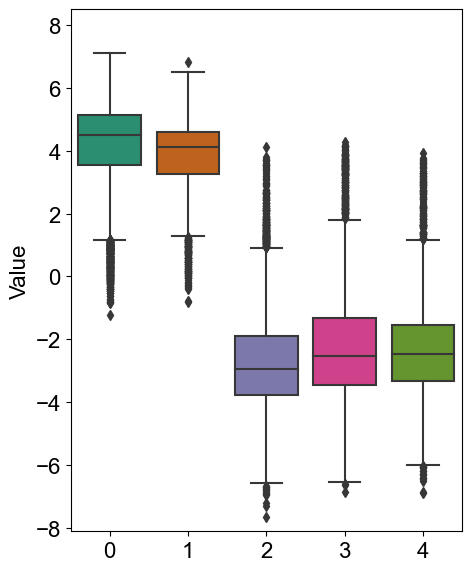

In [22]:

df_boxplot = pd.DataFrame([],columns=['Value','Label'])
for idx,g in enumerate([x1,x3,x5,x7,x9]):
    new_df = pd.DataFrame([])
    new_df["Value"] = list(g["Lum"])
    new_df["Label"] = [idx]*len(g["Lum"])
    df_boxplot = df_boxplot.append(new_df, ignore_index=True)

plt.figure(figsize=(5, 6))
sns.boxplot(x = df_boxplot["Label"], y = df_boxplot["Value"],palette='Dark2')
plt.xlabel("")
#plt.ylabel("NRF2 levels")
plt.ylim([-8.1,8.5])
plt.tight_layout()
plt.savefig("./plots/plots_Luminal_nature.png", dpi=800)

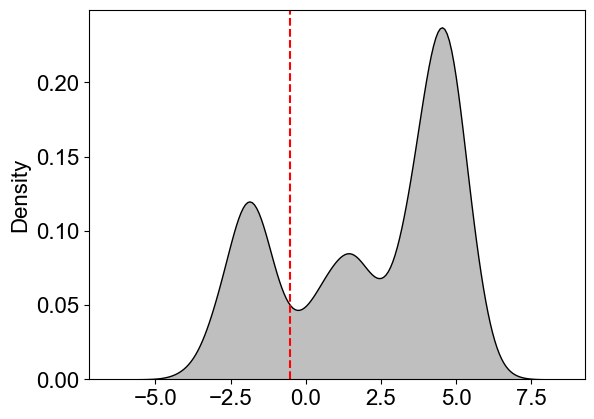

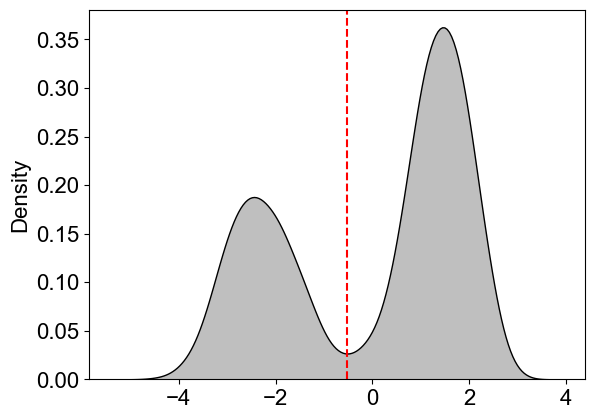

Lum 0.3224754752132274 0.8172915072685539
Lum_pert 0.31776464671863214 0.8546618717656346
Lum_H 0.0579862020784211 0.12960979342004592
Lum_H_pert 0.04057706814181544 0.1008683448820279
Bas_mes 0.33819462637906444 0.0028191514354179393
Bas_mes_pert 0.3195247674126226 0.0009796718099436689
Bas_H 0.11789363374377784 0.008598411878024714
Bas_H_pert 0.13106613024893135 0.008180259613029634
Bas_epi 0.16345006258550926 0.01221632288681107
Bas_epi_pert 0.19106738747799848 0.010335537594905707


In [93]:
#threshold = find_minima_in_distribution(list(df_basal_base["EMT"]),[-10,10],[0,10],1000)
#print(threshold)
sns.kdeplot(list(df_basal_base["EMT"]),color='black',fill=True)
plt.axvline(x=threshold, color='r', linestyle='--')
plt.show()
plt.close()

#threshold = find_minima_in_distribution(list(Res_score),[-10,10],[-10,10],1000)
#print(threshold)
sns.kdeplot(list(Res_score),color='black',fill=True)
plt.axvline(x=threshold, color='r', linestyle='--')
plt.show()
plt.close()





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import kde

# Generate random data for demonstration
x = list(EMT_score)
y = list(LBT_score)

# Perform KDE on the data
k = kde.gaussian_kde([x, y])
xmin, xmax = min(x), max(x)
ymin, ymax = min(y), max(y)
xi, yi = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Create an interactive 3D plot
fig = go.Figure(data=[
    go.Surface(x=xi, y=yi, z=zi.reshape(xi.shape), colorscale='RdBu_r')
])

# Set axes labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='EMT',
        yaxis_title='LBT',
        zaxis_title='Density'
    ),
    title='Interactive 3D Landscape from KDE'
)

# Show the plot
fig.show()
plt.close()

x = list(EMT_score_pert)
y = list(LBT_score_pert)

# Perform KDE on the data
k = kde.gaussian_kde([x, y])
xmin, xmax = min(x), max(x)
ymin, ymax = min(y), max(y)
xi, yi = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Create an interactive 3D plot
fig = go.Figure(data=[
    go.Surface(x=xi, y=yi, z=zi.reshape(xi.shape), colorscale='RdBu_r')
])

# Set axes labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='EMT',
        yaxis_title='LBT',
        zaxis_title='Density'
    ),
    title='Interactive 3D Landscape from KDE'
)

# Show the plot
fig.show()
plt.close()


c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


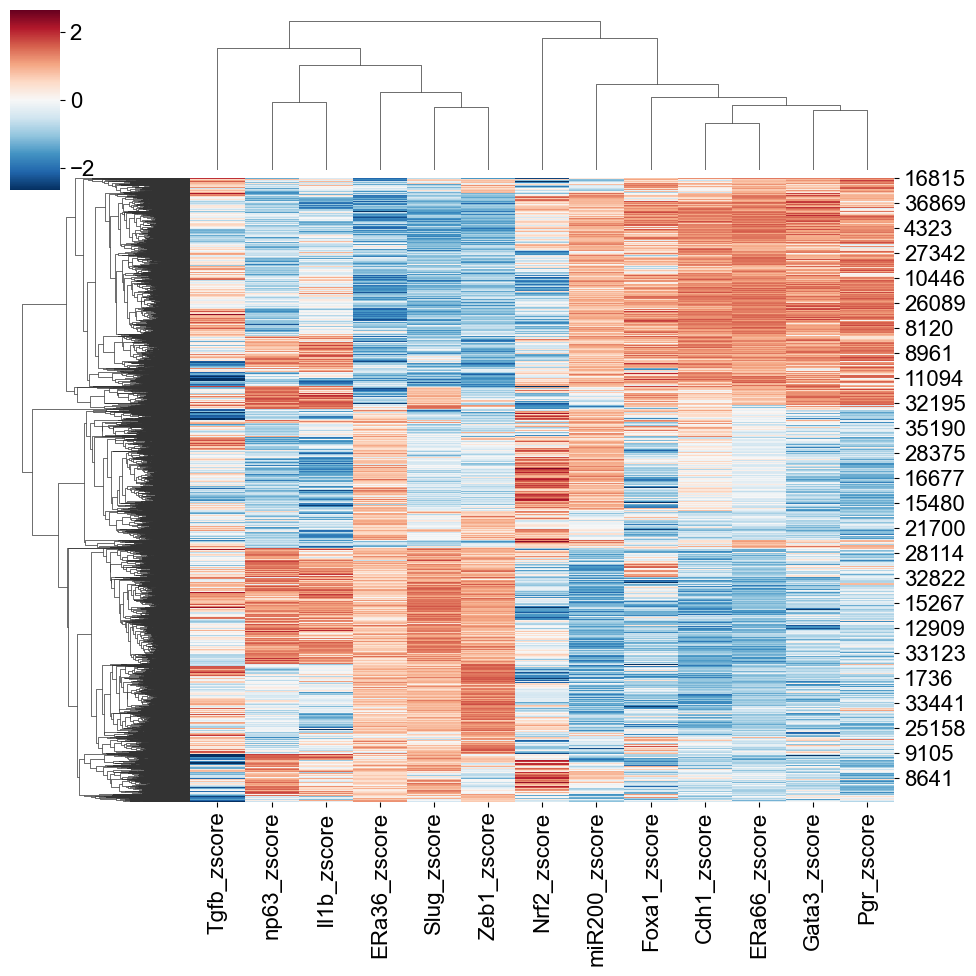

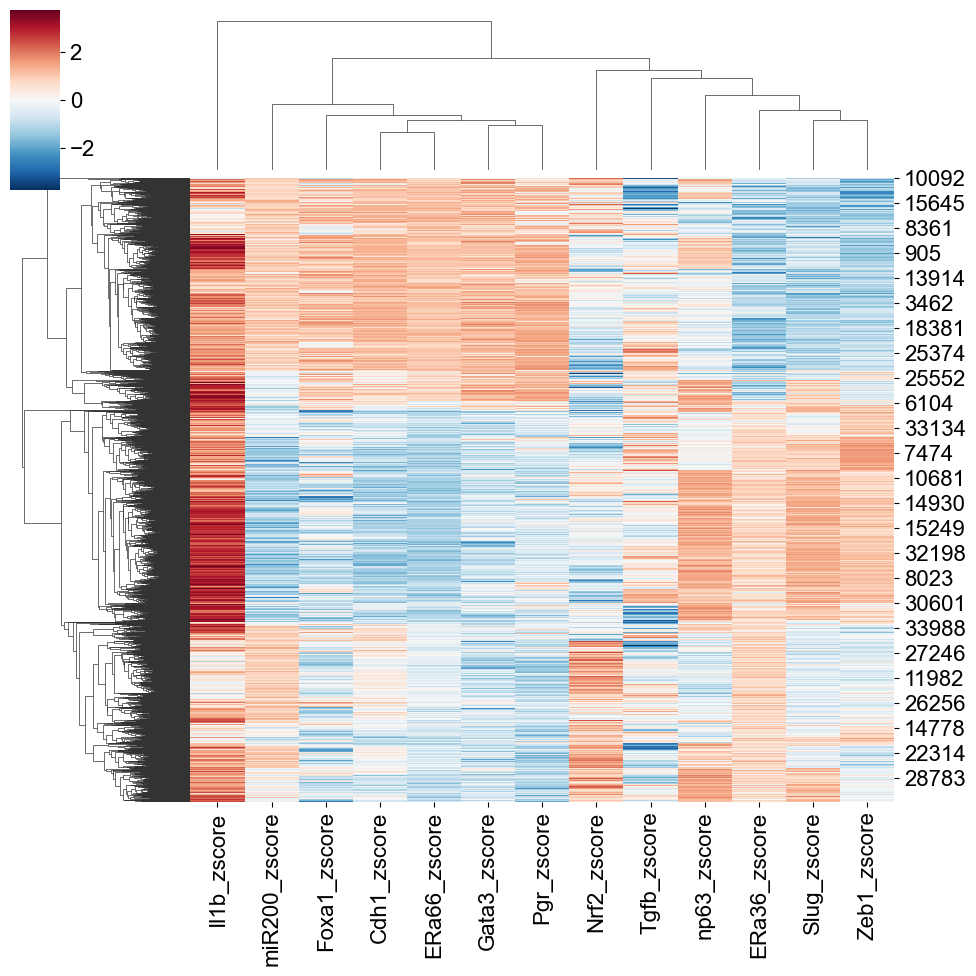

In [5]:
x1 = df_zscores_base[[i+"_zscore" for i in list_genes]]
sns.clustermap(x1.sample(n=10000),cmap="RdBu_r",vmin=-1*max(list(x1.max())))
plt.show()
plt.close()

x2 = df_zscores_pert[[i+"_zscore" for i in list_genes]]
sns.clustermap(x2.sample(n=10000),cmap="RdBu_r",vmin=-1*max(list(x2.max())))
plt.show()
plt.close()

In [22]:
df_scatter = pd.DataFrame([])
df_scatter["Epi"] = Epithelial
df_scatter["Mes"] = Mesenchymal
df_scatter["Res_score"] = Res_score
df_scatter["Lum"] = Luminal
df_scatter["Bas"] = Basal
df_scatter["pEMT"] = pEMT
df_scatter["Nrf2"] = df_zscores_base["Nrf2_zscore"]

df_scatter_pert = pd.DataFrame([])
df_scatter_pert["Epi"] = Epithelial_pert
df_scatter_pert["Mes"] = Mesenchymal_pert
df_scatter_pert["Res_score"] = Res_score_pert
df_scatter_pert["Lum"] = Luminal_pert
df_scatter_pert["Bas"] = Basal_pert
df_scatter_pert["pEMT"] = pEMT_pert
df_scatter_pert["Nrf2"] = df_zscores_pert["Nrf2_zscore"]

df_scatterbase = pd.DataFrame([])
df_scatterpert = pd.DataFrame([])

for col in list_genes:
    col_zscore = col + '_zscore'
    df_scatterbase[col_zscore] = (df_scatter[col] - df_scatter[col].mean())/df_scatter[col].std(ddof=0)

for col in list_genes:
    col_zscore = col + '_zscore'
    df_scatterpert[col_zscore] = (df_scatter_pert[col] - df_scatter[col].mean())/df_scatter[col].std(ddof=0)

sns.clustermap(df_scatterbase.sample(n=10000),cmap="RdBu_r",vmin=-1*max(list(df_scatterbase.max())))
plt.show()
plt.close()

sns.clustermap(df_scatterpert.sample(n=10000),cmap="RdBu_r",vmin=-1*max(list(df_scatterpert.max())))
plt.show()
plt.close()

KeyError: 'Slug'

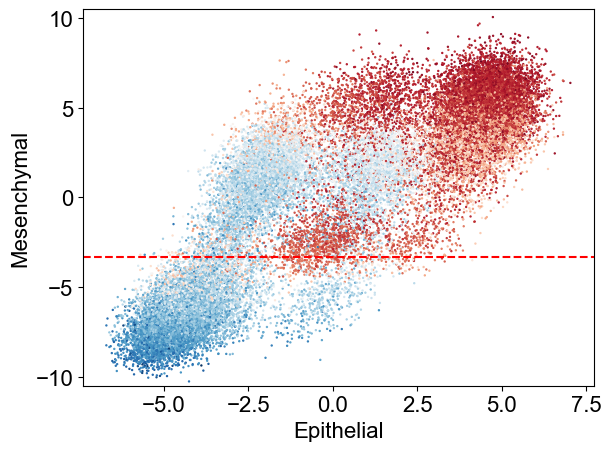

In [29]:
replicate_number = "r1"

list_genes = ['Slug','miR200','Zeb1','Cdh1','ERa66','ERa36','np63','Gata3','Foxa1','Pgr',"Nrf2"]

# base circuit
df_base = pd.read_csv("./circuit_4_WT/"+replicate_number+"/core_solution.dat", sep = "\t", header = None)
df_base.columns = ["parameter" ,"stability", "number"] + list_genes 
df_base = df_base[df_base["stability"] <= 6]


for col in list_genes:
    col_zscore = col + '_zscore'
    df_base[col_zscore] = (df_base[col] - df_base[col].mean())/df_base[col].std(ddof=0)
    

df_zscores_base = df_base[[i+"_zscore" for i in list_genes]]

df_scores_base = pd.DataFrame([])
Epithelial = df_zscores_base["miR200_zscore"] + df_zscores_base["Cdh1_zscore"]
Mesenchymal = df_zscores_base["Zeb1_zscore"] + df_zscores_base["Slug_zscore"]
EMT_score = Mesenchymal - Epithelial
Res_score = df_zscores_base["ERa36_zscore"] - df_zscores_base["ERa66_zscore"]
Luminal =  df_zscores_base["ERa66_zscore"] + df_zscores_base["Gata3_zscore"] + df_zscores_base["Foxa1_zscore"]  + df_zscores_base["Pgr_zscore"]
Basal = df_zscores_base["np63_zscore"] + df_zscores_base["Slug_zscore"]
LBT_score = Basal - Luminal
pEMT = Mesenchymal + Epithelial  - abs(EMT_score)
df_scores_base["LBT"] = LBT_score
df_scores_base["EMT"] = EMT_score
df_scores_base["Nrf2"] = df_zscores_base["Nrf2_zscore"]

lum_bas_threshold = -3.3230000000000004
df_luminal_base = df_scores_base[df_scores_base["LBT"] < lum_bas_threshold]
df_basal_base = df_scores_base[df_scores_base["LBT"] >= lum_bas_threshold]

pemt_epi_threshold = -0.6240000000000006
pemt_mes_threshold = 2.397
pemt_threshold_luminal = -1.6839999999999993

color_by = "pEMT"

plt.scatter(list(EMT_score), list(LBT_score), s = 0.5, c=Basal, cmap="RdBu_r")
#plt.scatter(list(EMT_score), list(LBT_score), s = 0.5 , c='black')
#sns.scatterplot(x=list(EMT_score), y=list(LBT_score),linewidth=0,s=3, c=df_zscores_base["Nrf2_zscore"], cmap="RdBu_r")
plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
#plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
plt.ylim([-10.5,10.5])
plt.legend('',frameon=False)
plt.xlabel("Epithelial")
plt.ylabel("Mesenchymal")
plt.tight_layout()
plt.show()
plt.close()



-1.986


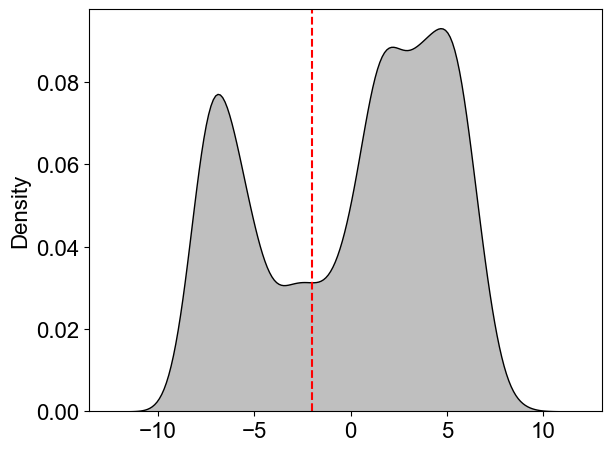

In [19]:
threshold = find_minima_in_distribution(list(LBT_score),[-10,10],[-3,10],1000)
print(threshold)
sns.kdeplot(list(LBT_score),color='black',fill=True)
plt.axvline(x=threshold, color='r', linestyle='--')
plt.tight_layout()
plt.show()
plt.close()

In [16]:
sns.kdeplot(list(EMT_score),color='black',fill=True)
plt.axvline(x=-3.1130000000000004, color='r', linestyle='--')
plt.axvline(x=-0.31499999999999995, color='r', linestyle='--')
plt.axvline(x=2.4699999999999998, color='r', linestyle='--')
plt.xlabel("EMT score")
plt.tight_layout()
plt.savefig("./plots/plots_EMT_score_WT.png", dpi=800)
plt.close()

In [22]:
sns.kdeplot(list(LBT_score),color='black',fill=True)
plt.axvline(x=-3.458, color='r', linestyle='--')
plt.axvline(x=-1.986, color='r', linestyle='--')
plt.xlabel("LBT score")
plt.tight_layout()
plt.savefig("./plots/plots_LBT_score_WT.png", dpi=800)
plt.close()

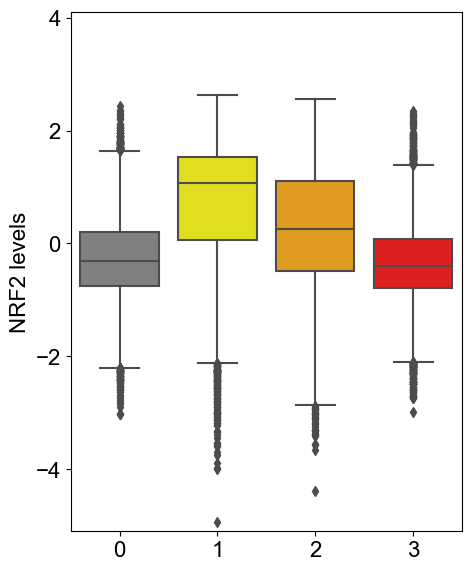

In [67]:
dfepi = df_scores_base[df_scores_base["EMT"] < -3.1130000000000004]
dfh1 = df_scores_base[(df_scores_base["EMT"] > -3.1130000000000004) & (df_scores_base["EMT"] < -0.31499999999999995)]
dfh2 = df_scores_base[(df_scores_base["EMT"] > -0.31499999999999995) & (df_scores_base["EMT"] < 2.4699999999999998)]
dfmes = df_scores_base[df_scores_base["EMT"] > 2.4699999999999998]

df_boxplot = pd.DataFrame([],columns=['Value','Label'])
for idx,g in enumerate([dfepi,dfh1,dfh2,dfmes]):
    new_df = pd.DataFrame([])
    new_df["Value"] = list(g["Nrf2"])
    new_df["Label"] = [idx]*len(g["Nrf2"])
    df_boxplot = df_boxplot.append(new_df, ignore_index=True)

plt.figure(figsize=(5, 6))
sns.boxplot(x = df_boxplot["Label"], y = df_boxplot["Value"],palette=['grey','yellow','orange','red'])
plt.xlabel("")
plt.ylabel("NRF2 levels")
plt.ylim([-5.1,4.1])
plt.tight_layout()
plt.savefig("./plots/plots_NRF2_boxplot.png", dpi=800)


c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:1188: UserWarning: The following kwargs were not used by contour: 'scatter'
  **contour_kws,


<Figure size 600x600 with 0 Axes>

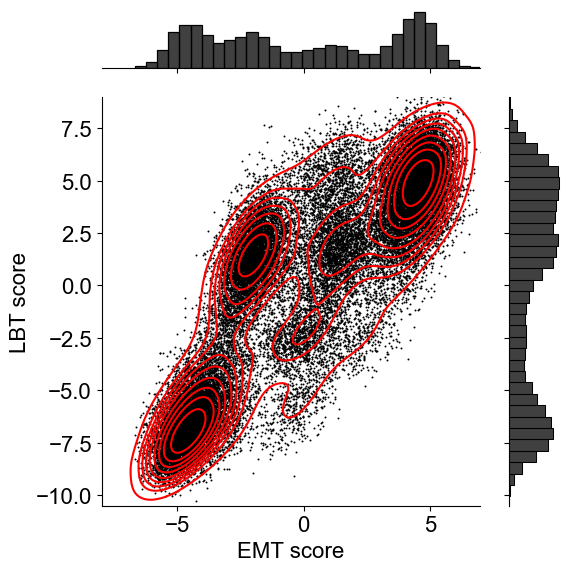

In [82]:
plt.figure(figsize=(6, 6))
#plt.scatter(list(EMT_score), list(LBT_score), s = 0.5, c=Basal, cmap="RdBu_r")
sns.jointplot(x = list(EMT_score), y = list(LBT_score), s = 2, linewidth=0 , color='black')
sns.kdeplot(x = list(EMT_score), y = list(LBT_score),scatter=False, color='red')
#sns.scatterplot(x=list(EMT_score), y=list(LBT_score),linewidth=0,s=3, c=df_zscores_base["Nrf2_zscore"], cmap="RdBu_r")
#plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
#plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
plt.ylim([-10.5,9])
plt.xlim([-8,7])
plt.legend('',frameon=False)
plt.xlabel("EMT score")
plt.ylabel("LBT score")
plt.tight_layout()
plt.savefig("./plots/plots_scatter_EMT_LBT.png", dpi=800)


c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:1188: UserWarning: The following kwargs were not used by contour: 'scatter'
  **contour_kws,


<Figure size 600x600 with 0 Axes>

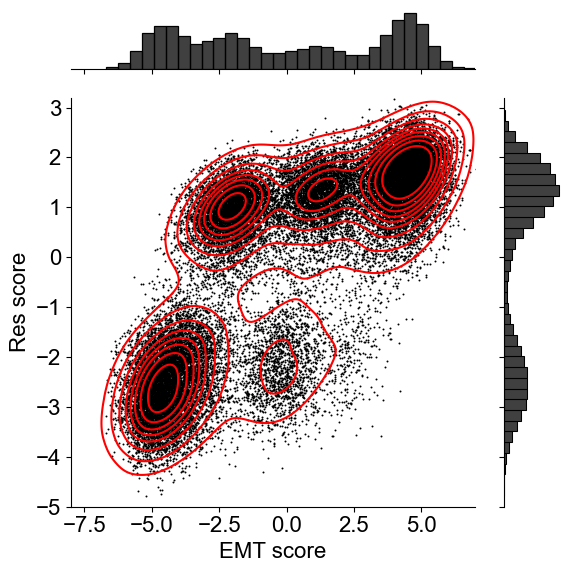

In [92]:
plt.figure(figsize=(6, 6))
#plt.scatter(list(EMT_score), list(LBT_score), s = 0.5, c=Basal, cmap="RdBu_r")
sns.jointplot(x = list(EMT_score), y = list(Res_score), s = 2, linewidth=0 , color='black')
sns.kdeplot(x = list(EMT_score), y = list(Res_score),scatter=False, color='red')
#sns.scatterplot(x=list(EMT_score), y=list(LBT_score),linewidth=0,s=3, c=df_zscores_base["Nrf2_zscore"], cmap="RdBu_r")
#plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
#plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
plt.ylim([-5,3.2])
plt.xlim([-8,7])
plt.legend('',frameon=False)
plt.xlabel("EMT score")
plt.ylabel("Res score")
plt.tight_layout()
plt.savefig("./plots/plots_scatter_EMT_Res.png", dpi=800)

c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:1188: UserWarning: The following kwargs were not used by contour: 'scatter'
  **contour_kws,


<Figure size 600x600 with 0 Axes>

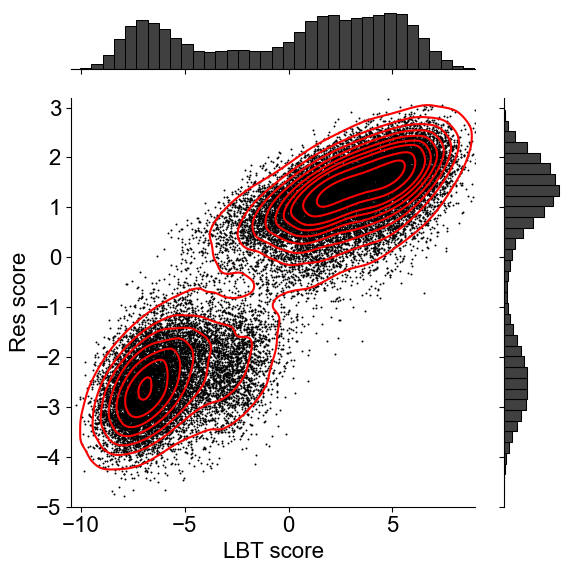

In [94]:
plt.figure(figsize=(6, 6))
#plt.scatter(list(EMT_score), list(LBT_score), s = 0.5, c=Basal, cmap="RdBu_r")
sns.jointplot(x = list(LBT_score), y = list(Res_score), s = 2, linewidth=0 , color='black')
sns.kdeplot(x = list(LBT_score), y = list(Res_score),scatter=False, color='red')
#sns.scatterplot(x=list(EMT_score), y=list(LBT_score),linewidth=0,s=3, c=df_zscores_base["Nrf2_zscore"], cmap="RdBu_r")
#plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
#plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
plt.xlim([-10.5,9])
plt.ylim([-5,3.2])
plt.legend('',frameon=False)
plt.xlabel("LBT score")
plt.ylabel("Res score")
plt.tight_layout()
plt.savefig("./plots/plots_scatter_LBT_Res.png", dpi=800)

In [86]:
x1 = df_zscores_base[[i+"_zscore" for i in list_genes]]
sns.clustermap(x1.sample(n=15000),cmap="RdBu_r",vmin=-1*max(list(x1.max())))
plt.savefig("./plots/plots_clustermap_allgenes.png", dpi=800)
plt.close()

df_scatter = pd.DataFrame([])
df_scatter["Epi"] = Epithelial
df_scatter["Mes"] = Mesenchymal
df_scatter["EMT"] = Mesenchymal - Epithelial
df_scatter["Res_score"] = Res_score
df_scatter["Lum"] = Luminal
df_scatter["Bas"] = Basal
df_scatter["LBT"] = Basal - Luminal
df_scatter["pEMT"] = pEMT
df_scatter["Nrf2"] = df_zscores_base["Nrf2_zscore"]

df_scatterbase = pd.DataFrame([])

for col in ['EMT','LBT','Res_score','pEMT']:
    col_zscore = col + '_zscore'
    df_scatterbase[col_zscore] = (df_scatter[col] - df_scatter[col].mean())/df_scatter[col].std(ddof=0)

sns.clustermap(df_scatterbase.sample(n=15000),cmap="RdBu_r",vmin=-1*max(list(df_scatterbase.max())))
plt.savefig("./plots/plots_clustermap_pathways.png", dpi=800)
plt.close()


c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


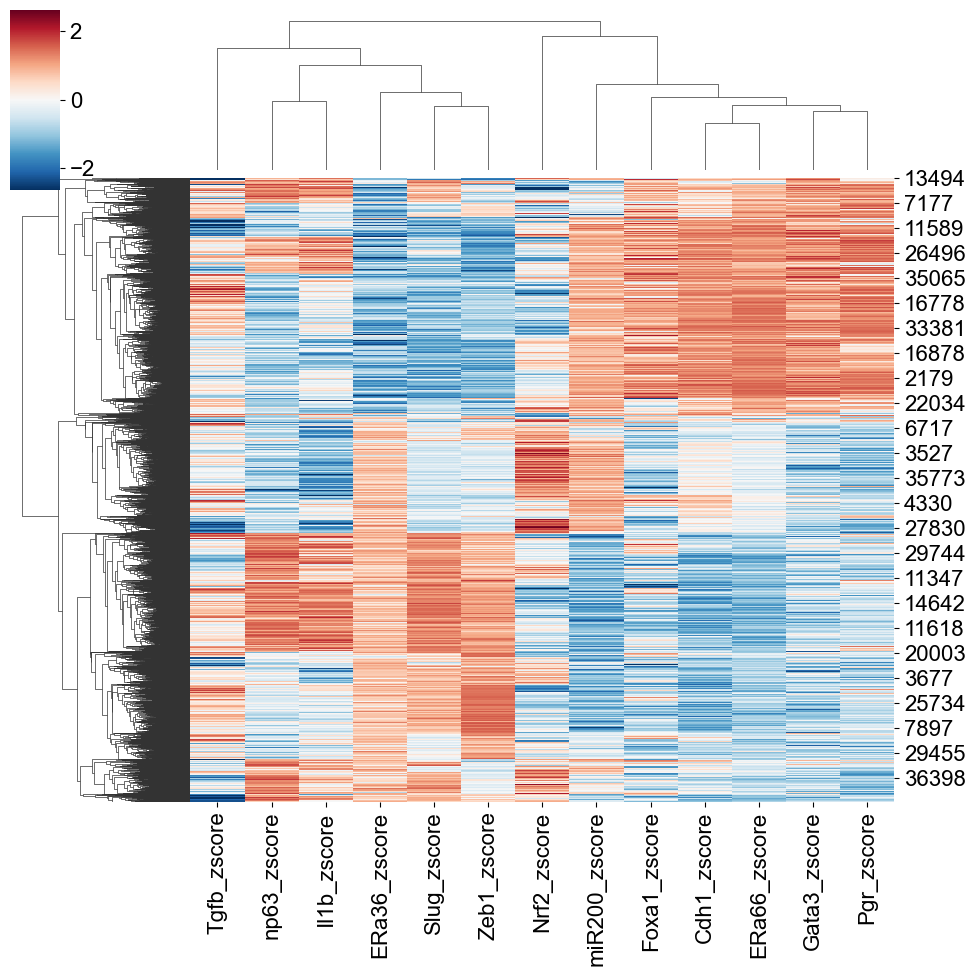

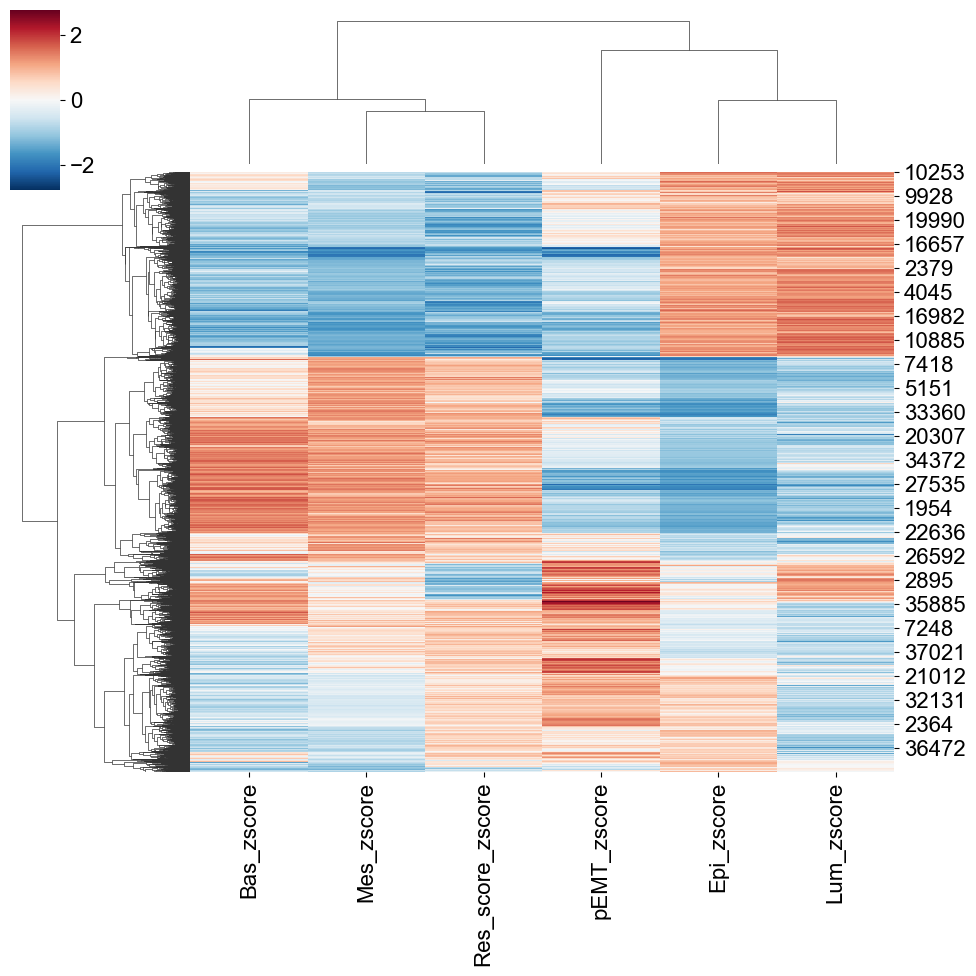

In [23]:
x1 = df_zscores_base[[i+"_zscore" for i in list_genes]]
sns.clustermap(x1.sample(n=10000),cmap="RdBu_r",vmin=-1*max(list(x1.max())))
plt.show()
plt.close()

df_scatter = pd.DataFrame([])
df_scatter["Epi"] = Epithelial
df_scatter["Mes"] = Mesenchymal
df_scatter["Res_score"] = Res_score
df_scatter["Lum"] = Luminal
df_scatter["Bas"] = Basal
df_scatter["pEMT"] = pEMT
df_scatter["Nrf2"] = df_zscores_base["Nrf2_zscore"]

df_scatterbase = pd.DataFrame([])

for col in ['Epi','Mes','Lum','Bas','Res_score','pEMT']:
    col_zscore = col + '_zscore'
    df_scatterbase[col_zscore] = (df_scatter[col] - df_scatter[col].mean())/df_scatter[col].std(ddof=0)

sns.clustermap(df_scatterbase,cmap="RdBu_r",vmin=-1*max(list(df_scatterbase.max())))
plt.show()
plt.close()



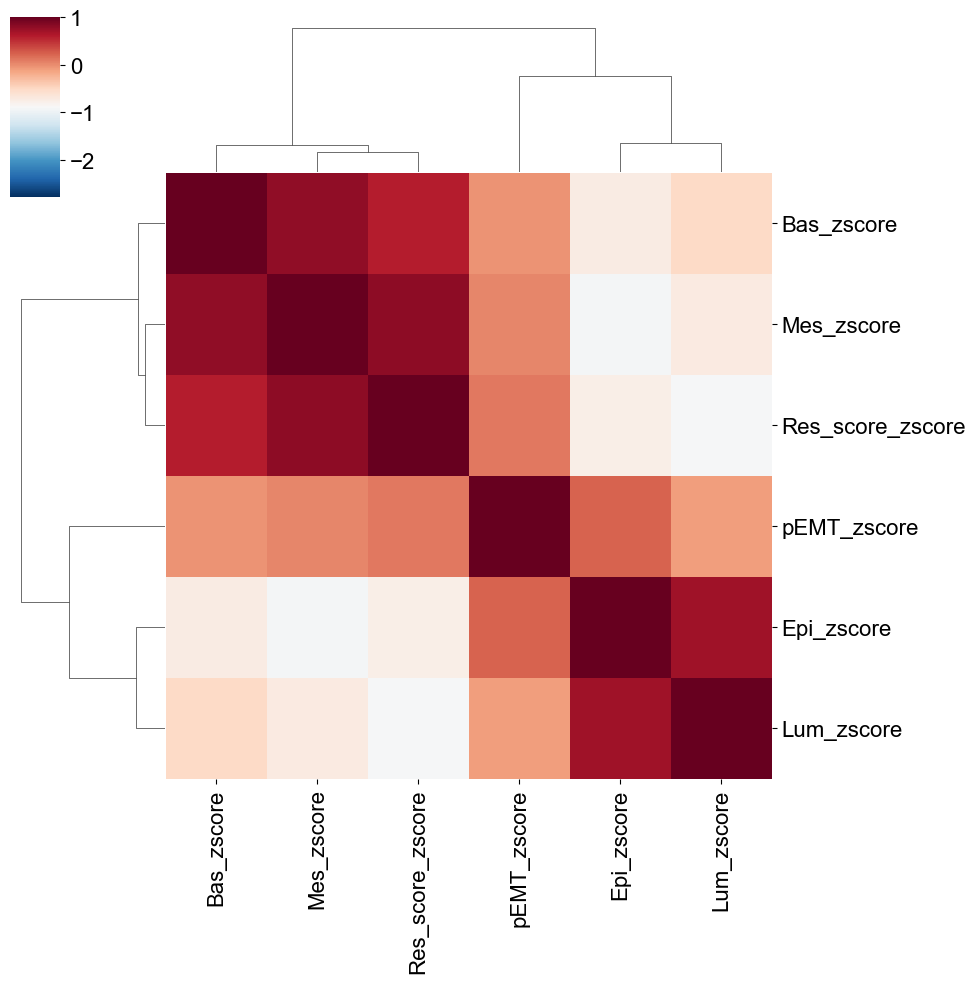

In [25]:
# code to plot barcharts
sns.clustermap(df_scatterbase.corr(method='pearson'),cmap="RdBu_r",vmin=-1*max(list(df_scatterbase.max())))